In [ ]:
%pip install torch torchvision torchaudio matplotlib scikit-learnA opencv-python timm tqdm torchsummary

In [ ]:
%conda install pytorch torchvision torchaudio cudatoolkit=11.8 -c pytorch

In [1]:
# -*- coding: utf-8 -*-
"""
Slicewise GAN Training and Evaluation for BraTS2020
(4-class segmentation on 2D slices converted to `.npy` files)
Includes training/validation curves visualization.
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm


c:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:

IMG_SIZE = 128
BATCH_SIZE = 8
NUM_CLASSES = 4
EPOCHS_SEG = 50
EPOCHS_GAN = 50
LR_SEG = 1e-4
LR_GAN = 2e-4
BETA1 = 0.5
L1_LAMBDA = 100
# Data paths
data_root = "D:\mini_proj\BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/input_data_128"
train_img_dir = os.path.join(data_root, "train/images_slicewise")
train_msk_dir = os.path.join(data_root, "train/masks_slicewise")
val_img_dir   = os.path.join(data_root, "val/images_slicewise")
val_msk_dir   = os.path.join(data_root, "val/masks_slicewise")


In [8]:

# --- Dataset ---
class BratsSlice(Dataset):
    def __init__(self, img_dir, msk_dir):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*", "slice_*.npy")))
        self.msk_paths = [p.replace(img_dir, msk_dir) for p in self.img_paths]
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img = np.load(self.img_paths[idx])  # HxWx3
        msk = np.load(self.msk_paths[idx])  # HxWxNUM_CLASSES

        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        msk = torch.from_numpy(msk).permute(2, 0, 1).float()

        # Ensure consistent IMG_SIZE
        if img.shape[1:] != (IMG_SIZE, IMG_SIZE):
            img = F.interpolate(img.unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False).squeeze(0)
        if msk.shape[1:] != (IMG_SIZE, IMG_SIZE):
            msk = F.interpolate(msk.unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode='nearest').squeeze(0)

        return img, msk

# --- Models ---

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=2, ff_dim=128):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x_flat = x.flatten(2).permute(0, 2, 1)  # B, H*W, C
        x2 = self.attn(self.norm1(x_flat), self.norm1(x_flat), self.norm1(x_flat))[0]
        x_flat = x_flat + x2
        x2 = self.ff(self.norm2(x_flat))
        x_flat = x_flat + x2
        return x_flat.permute(0, 2, 1).view(b, c, h, w)

class Hybrid(nn.Module):
    """U-Net with EfficientNet-B3 encoder and transformer-based decoder blocks"""
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = timm.create_model(
            'tf_efficientnet_b3', pretrained=True,
            features_only=True, out_indices=[0,1,2,3,4], in_chans=3
        )
        chs = self.encoder.feature_info.channels()

        # Decoder: up-convs and transformer+projection blocks
        self.up_convs = nn.ModuleList()
        self.transformer_blocks = nn.ModuleList()
        self.proj_convs = nn.ModuleList()
        for i in reversed(range(len(chs)-1)):
            # upsample
            self.up_convs.append(nn.ConvTranspose2d(chs[i+1], chs[i], kernel_size=2, stride=2))
            # transformer on concatenated features
            self.transformer_blocks.append(TransformerBlock(dim=chs[i]*2))
            # project back to chs[i]
            self.proj_convs.append(nn.Conv2d(chs[i]*2, chs[i], kernel_size=1))

        # Final upsample + output
        self.final_up = nn.ConvTranspose2d(chs[0], 32, kernel_size=2, stride=2)
        self.conv_last = nn.Conv2d(32, NUM_CLASSES, kernel_size=1)

    def forward(self, x):
        feats = self.encoder(x)
        x = feats[-1]

        for up, trans, proj, skip in zip(self.up_convs, self.transformer_blocks, self.proj_convs, reversed(feats[:-1])):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
            x = trans(x)
            x = proj(x)

        x = F.relu(self.final_up(x))
        return torch.softmax(self.conv_last(x), dim=1)

# --- Loss & Metric ---
def dice_coef(y_true,y_pred,eps=1e-5):
    if y_pred.shape[2:]!=y_true.shape[2:]: y_pred=F.interpolate(y_pred,size=y_true.shape[2:],mode='bilinear',align_corners=False)
    t=y_true.view(y_true.size(0),y_true.size(1),-1); p=y_pred.view(y_pred.size(0),y_pred.size(1),-1)
    inter=(t*p).sum(-1); denom=t.sum(-1)+p.sum(-1)+eps
    return ((2*inter+eps)/denom).mean()
def dice_loss(y_true,y_pred): return 1-dice_coef(y_true,y_pred)


In [9]:
# --- Data ---
train_ds=BratsSlice(train_img_dir,train_msk_dir)
val_ds  =BratsSlice(val_img_dir,  val_msk_dir)
train_ld=DataLoader(train_ds,BATCH_SIZE,True)
val_ld  =DataLoader(val_ds,  BATCH_SIZE,False)

# --- Initialize ---
hybrid = Hybrid().to(device)
opt_u=optim.Adam(hybrid.parameters(),lr=LR_SEG)

# To store metrics
seg_train_loss, seg_val_dice = [], []


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [ ]:
%pip install torchinfo

In [ ]:


from torchinfo import summary

# print a summary: batch size 1, 3 input channels, HxW = IMG_SIZE×IMG_SIZE
summary(
    hybrid,
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=("input_size", "output_size", "num_params"),
    col_width=20,
    row_settings=("var_names",)
)


Layer (type (var_name))                                 Input Shape          Output Shape         Param #
hybrid (hybrid)                                             [1, 3, 128, 128]     [1, 4, 128, 128]     --
├─EfficientNetFeatures (encoder)                        [1, 3, 128, 128]     [1, 24, 64, 64]      --
│    └─Conv2dSame (conv_stem)                           [1, 3, 128, 128]     [1, 40, 64, 64]      1,080
│    └─BatchNormAct2d (bn1)                             [1, 40, 64, 64]      [1, 40, 64, 64]      80
│    │    └─Identity (drop)                             [1, 40, 64, 64]      [1, 40, 64, 64]      --
│    │    └─SiLU (act)                                  [1, 40, 64, 64]      [1, 40, 64, 64]      --
│    └─Sequential (blocks)                              --                   --                   --
│    │    └─Sequential (0)                              [1, 40, 64, 64]      [1, 24, 64, 64]      3,504
│    │    └─Sequential (1)                              [1, 24, 64, 64]     

In [10]:


from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# --- One‐time 90/10 split of your training set ---
full_ds    = BratsSlice(train_img_dir, train_msk_dir)
indices    = list(range(len(full_ds)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.1, shuffle=True, random_state=42
)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)



In [ ]:
# --- Single training run for 20 epochs ---

best_u = 0

for epoch in range(1, EPOCHS_SEG+1):
  
    hybrid.train()
    epoch_loss = 0
    epoch_dice = 0
    # Training with tqdm
    for x, y in tqdm(train_ld, desc=f"Seg Train Epoch {epoch}/{EPOCHS_SEG}"):
        x, y = x.to(device), y.to(device)
        p = hybrid(x)
        loss = dice_loss(y, p)
        # Backprop
        opt_u.zero_grad()
        loss.backward()
        opt_u.step()
        epoch_loss += loss.item()
        # Training Dice
        epoch_dice += dice_coef(y, p).item()
    train_loss = epoch_loss / len(train_ld)
    train_dice = epoch_dice / len(train_ld)
    seg_train_loss.append(train_loss)

    # Validation with tqdm
    hybrid.eval()
    vd = 0
    with torch.no_grad():
        for x, y in tqdm(val_ld, desc=f"Seg Val Epoch {epoch}/{EPOCHS_SEG}"):
            x, y = x.to(device), y.to(device)
            vd += dice_coef(y, hybrid(x)).item()
    val_dice = vd / len(val_ld)
    seg_val_dice.append(val_dice)

    if val_dice > best_u:
        best_u = val_dice
        torch.save(hybrid.state_dict(), "hybridModel.pth")

    print(f"Epoch {epoch}/{EPOCHS_SEG} | Train Dice {train_dice:.4f} | Val Dice {val_dice:.4f} | Train Loss {1-train_dice:.4f} | Val Loss {1-val_dice:.4f}")

# Freeze U-Net
hybrid.eval()
for p in hybrid.parameters(): p.requires_grad=False
hybrid.eval()
for p in hybrid.parameters(): p.requires_grad=False
hybrid.eval(); [p.requires_grad_(False) for p in hybrid.parameters()]



Seg Val Epoch 1/50: 100%|██████████| 413/413 [00:46<00:00,  8.93it/s]


Epoch 1/50 | Train Dice 0.7280 | Val Dice 0.7875 | Train Loss 0.2720 | Val Loss 0.2125


Seg Val Epoch 2/50: 100%|██████████| 413/413 [00:46<00:00,  8.81it/s]


Epoch 2/50 | Train Dice 0.8078 | Val Dice 0.8377 | Train Loss 0.1922 | Val Loss 0.1623


Seg Val Epoch 3/50: 100%|██████████| 413/413 [00:46<00:00,  8.88it/s]


Epoch 3/50 | Train Dice 0.8366 | Val Dice 0.8429 | Train Loss 0.1634 | Val Loss 0.1571


Seg Val Epoch 4/50: 100%|██████████| 413/413 [00:30<00:00, 13.65it/s]


Epoch 4/50 | Train Dice 0.8450 | Val Dice 0.8528 | Train Loss 0.1550 | Val Loss 0.1472


Seg Val Epoch 5/50: 100%|██████████| 413/413 [00:36<00:00, 11.36it/s]


Epoch 5/50 | Train Dice 0.8547 | Val Dice 0.8510 | Train Loss 0.1453 | Val Loss 0.1490


Seg Val Epoch 6/50: 100%|██████████| 413/413 [00:36<00:00, 11.45it/s]


Epoch 6/50 | Train Dice 0.8542 | Val Dice 0.8580 | Train Loss 0.1458 | Val Loss 0.1420


Seg Val Epoch 7/50: 100%|██████████| 413/413 [00:34<00:00, 12.11it/s]


Epoch 7/50 | Train Dice 0.8601 | Val Dice 0.8631 | Train Loss 0.1399 | Val Loss 0.1369


Seg Val Epoch 8/50: 100%|██████████| 413/413 [00:37<00:00, 10.91it/s]


Epoch 8/50 | Train Dice 0.8618 | Val Dice 0.8661 | Train Loss 0.1382 | Val Loss 0.1339


Seg Val Epoch 9/50: 100%|██████████| 413/413 [00:37<00:00, 10.88it/s]


Epoch 9/50 | Train Dice 0.8648 | Val Dice 0.8658 | Train Loss 0.1352 | Val Loss 0.1342


Seg Val Epoch 10/50: 100%|██████████| 413/413 [00:37<00:00, 11.14it/s]


Epoch 10/50 | Train Dice 0.8690 | Val Dice 0.8689 | Train Loss 0.1310 | Val Loss 0.1311


Seg Val Epoch 11/50: 100%|██████████| 413/413 [00:37<00:00, 10.90it/s]


Epoch 11/50 | Train Dice 0.8731 | Val Dice 0.8680 | Train Loss 0.1269 | Val Loss 0.1320


Seg Val Epoch 12/50: 100%|██████████| 413/413 [00:36<00:00, 11.19it/s]


Epoch 12/50 | Train Dice 0.8750 | Val Dice 0.8771 | Train Loss 0.1250 | Val Loss 0.1229


Seg Val Epoch 13/50: 100%|██████████| 413/413 [00:33<00:00, 12.29it/s]


Epoch 13/50 | Train Dice 0.8774 | Val Dice 0.8754 | Train Loss 0.1226 | Val Loss 0.1246


Seg Val Epoch 14/50: 100%|██████████| 413/413 [00:41<00:00,  9.90it/s]


Epoch 14/50 | Train Dice 0.8780 | Val Dice 0.8818 | Train Loss 0.1220 | Val Loss 0.1182


Seg Val Epoch 15/50: 100%|██████████| 413/413 [00:36<00:00, 11.47it/s]


Epoch 15/50 | Train Dice 0.8813 | Val Dice 0.8833 | Train Loss 0.1187 | Val Loss 0.1167


Seg Val Epoch 16/50: 100%|██████████| 413/413 [00:39<00:00, 10.51it/s]


Epoch 16/50 | Train Dice 0.8826 | Val Dice 0.8764 | Train Loss 0.1174 | Val Loss 0.1236


Seg Val Epoch 17/50: 100%|██████████| 413/413 [00:38<00:00, 10.81it/s]


Epoch 17/50 | Train Dice 0.8845 | Val Dice 0.8852 | Train Loss 0.1155 | Val Loss 0.1148


Seg Val Epoch 18/50: 100%|██████████| 413/413 [00:37<00:00, 11.10it/s]


Epoch 18/50 | Train Dice 0.8871 | Val Dice 0.8879 | Train Loss 0.1129 | Val Loss 0.1121


Seg Val Epoch 19/50: 100%|██████████| 413/413 [00:36<00:00, 11.38it/s]


Epoch 19/50 | Train Dice 0.8890 | Val Dice 0.8895 | Train Loss 0.1110 | Val Loss 0.1105


Seg Val Epoch 20/50: 100%|██████████| 413/413 [00:35<00:00, 11.75it/s]


Epoch 20/50 | Train Dice 0.8912 | Val Dice 0.8910 | Train Loss 0.1088 | Val Loss 0.1090


Seg Val Epoch 21/50: 100%|██████████| 413/413 [00:37<00:00, 11.05it/s]


Epoch 21/50 | Train Dice 0.8935 | Val Dice 0.8928 | Train Loss 0.1065 | Val Loss 0.1072


Seg Val Epoch 22/50: 100%|██████████| 413/413 [00:38<00:00, 10.88it/s]


Epoch 22/50 | Train Dice 0.8958 | Val Dice 0.8945 | Train Loss 0.1042 | Val Loss 0.1055


Seg Val Epoch 23/50: 100%|██████████| 413/413 [00:36<00:00, 11.41it/s]


Epoch 23/50 | Train Dice 0.8977 | Val Dice 0.8966 | Train Loss 0.1023 | Val Loss 0.1034


Seg Val Epoch 24/50: 100%|██████████| 413/413 [00:37<00:00, 11.12it/s]


Epoch 24/50 | Train Dice 0.8995 | Val Dice 0.8980 | Train Loss 0.1005 | Val Loss 0.1020


Seg Val Epoch 25/50: 100%|██████████| 413/413 [00:35<00:00, 11.66it/s]


Epoch 25/50 | Train Dice 0.9013 | Val Dice 0.8992 | Train Loss 0.0987 | Val Loss 0.1008


Seg Val Epoch 26/50: 100%|██████████| 413/413 [00:38<00:00, 10.79it/s]


Epoch 26/50 | Train Dice 0.9029 | Val Dice 0.9005 | Train Loss 0.0971 | Val Loss 0.0995


Seg Val Epoch 27/50: 100%|██████████| 413/413 [00:36<00:00, 11.40it/s]


Epoch 27/50 | Train Dice 0.9045 | Val Dice 0.9018 | Train Loss 0.0955 | Val Loss 0.0982


Seg Val Epoch 28/50: 100%|██████████| 413/413 [00:37<00:00, 11.15it/s]


Epoch 28/50 | Train Dice 0.9060 | Val Dice 0.9033 | Train Loss 0.0940 | Val Loss 0.0967


Seg Val Epoch 29/50: 100%|██████████| 413/413 [00:39<00:00, 10.55it/s]


Epoch 29/50 | Train Dice 0.9074 | Val Dice 0.9045 | Train Loss 0.0926 | Val Loss 0.0955


Seg Val Epoch 30/50: 100%|██████████| 413/413 [00:36<00:00, 11.42it/s]


Epoch 30/50 | Train Dice 0.9088 | Val Dice 0.9059 | Train Loss 0.0912 | Val Loss 0.0941


Seg Val Epoch 31/50: 100%|██████████| 413/413 [00:37<00:00, 11.09it/s]


Epoch 31/50 | Train Dice 0.9101 | Val Dice 0.9070 | Train Loss 0.0899 | Val Loss 0.0930


Seg Val Epoch 32/50: 100%|██████████| 413/413 [00:38<00:00, 10.82it/s]


Epoch 32/50 | Train Dice 0.9115 | Val Dice 0.9083 | Train Loss 0.0885 | Val Loss 0.0917


Seg Val Epoch 33/50: 100%|██████████| 413/413 [00:35<00:00, 11.70it/s]


Epoch 33/50 | Train Dice 0.9128 | Val Dice 0.9095 | Train Loss 0.0872 | Val Loss 0.0905


Seg Val Epoch 34/50: 100%|██████████| 413/413 [00:37<00:00, 11.11it/s]


Epoch 34/50 | Train Dice 0.9140 | Val Dice 0.9106 | Train Loss 0.0860 | Val Loss 0.0894


Seg Val Epoch 35/50: 100%|██████████| 413/413 [00:36<00:00, 11.35it/s]


Epoch 35/50 | Train Dice 0.9152 | Val Dice 0.9117 | Train Loss 0.0848 | Val Loss 0.0883


Seg Val Epoch 36/50: 100%|██████████| 413/413 [00:38<00:00, 10.75it/s]


Epoch 36/50 | Train Dice 0.9163 | Val Dice 0.9128 | Train Loss 0.0837 | Val Loss 0.0872


Seg Val Epoch 37/50: 100%|██████████| 413/413 [00:37<00:00, 11.18it/s]


Epoch 37/50 | Train Dice 0.9175 | Val Dice 0.9139 | Train Loss 0.0825 | Val Loss 0.0861


Seg Val Epoch 38/50: 100%|██████████| 413/413 [00:35<00:00, 11.69it/s]


Epoch 38/50 | Train Dice 0.9186 | Val Dice 0.9148 | Train Loss 0.0814 | Val Loss 0.0852


Seg Val Epoch 39/50: 100%|██████████| 413/413 [00:39<00:00, 10.60it/s]


Epoch 39/50 | Train Dice 0.9197 | Val Dice 0.9157 | Train Loss 0.0803 | Val Loss 0.0843


Seg Val Epoch 40/50: 100%|██████████| 413/413 [00:36<00:00, 11.44it/s]


Epoch 40/50 | Train Dice 0.9208 | Val Dice 0.9165 | Train Loss 0.0792 | Val Loss 0.0835


Seg Val Epoch 41/50: 100%|██████████| 413/413 [00:37<00:00, 11.08it/s]


Epoch 41/50 | Train Dice 0.9219 | Val Dice 0.9173 | Train Loss 0.0781 | Val Loss 0.0827


Seg Val Epoch 42/50: 100%|██████████| 413/413 [00:38<00:00, 10.85it/s]


Epoch 42/50 | Train Dice 0.9229 | Val Dice 0.9181 | Train Loss 0.0771 | Val Loss 0.0819


Seg Val Epoch 43/50: 100%|██████████| 413/413 [00:36<00:00, 11.47it/s]


Epoch 43/50 | Train Dice 0.9239 | Val Dice 0.9188 | Train Loss 0.0761 | Val Loss 0.0812


Seg Val Epoch 44/50: 100%|██████████| 413/413 [00:37<00:00, 11.14it/s]


Epoch 44/50 | Train Dice 0.9250 | Val Dice 0.9195 | Train Loss 0.0750 | Val Loss 0.0805


Seg Val Epoch 45/50: 100%|██████████| 413/413 [00:35<00:00, 11.77it/s]


Epoch 45/50 | Train Dice 0.9261 | Val Dice 0.9201 | Train Loss 0.0739 | Val Loss 0.0799


Seg Val Epoch 46/50: 100%|██████████| 413/413 [00:38<00:00, 10.78it/s]


Epoch 46/50 | Train Dice 0.9271 | Val Dice 0.9207 | Train Loss 0.0729 | Val Loss 0.0793


Seg Val Epoch 47/50: 100%|██████████| 413/413 [00:37<00:00, 11.19it/s]


Epoch 47/50 | Train Dice 0.9282 | Val Dice 0.9212 | Train Loss 0.0718 | Val Loss 0.0788


Seg Val Epoch 48/50: 100%|██████████| 413/413 [00:36<00:00, 11.45it/s]


Epoch 48/50 | Train Dice 0.9293 | Val Dice 0.9217 | Train Loss 0.0707 | Val Loss 0.0783


Seg Val Epoch 49/50: 100%|██████████| 413/413 [00:39<00:00, 10.62it/s]


Epoch 49/50 | Train Dice 0.9304 | Val Dice 0.9221 | Train Loss 0.0696 | Val Loss 0.0779


Seg Val Epoch 50/50: 100%|██████████| 413/413 [00:37<00:00, 11.06it/s]


Epoch 50/50 | Train Dice 0.9314 | Val Dice 0.9225 | Train Loss 0.0686 | Val Loss 0.0775


In [ ]:
hybrid= Hybrid().to(device)
hybrid.load_state_dict(torch.load("hybridModel"))

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
C:\Users\k7adi\AppData\Local\Temp\ipykernel_3104\301378972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start settin

<All keys matched successfully>

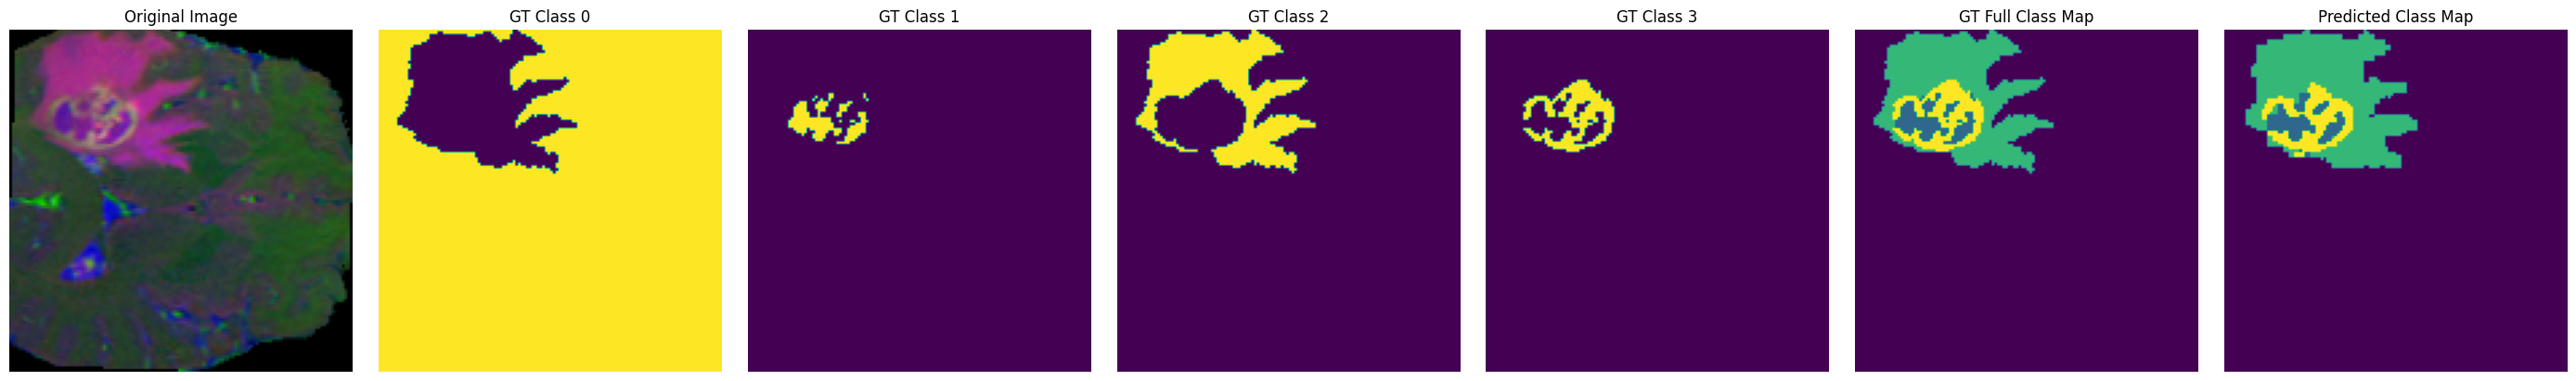

In [16]:
# --- Mid-training Sample Check ---
# After hybrid training, inspect slice 55 of volume 82 from validation

sample_img = np.load(os.path.join(val_img_dir, "image_82", "slice_055.npy"))  # HxWx3
sample_msk = np.load(os.path.join(val_msk_dir, "image_82", "slice_055.npy"))  # HxWxNUM_CLASSES

# To tensor and batch
img_t = torch.from_numpy(sample_img).permute(2,0,1).unsqueeze(0).float().to(device)
hybrid.eval()
with torch.no_grad():
    pred_m = hybrid(img_t)  # 1xC xHxW

pred_m = pred_m.squeeze(0).cpu().numpy()  # CxHxW

# Convert one-hot ground truth mask to class index map
gt_class_map = np.argmax(sample_msk, axis=-1)  # HxW

# Plot original image, ground truth masks (per class), full ground truth, and prediction
fig, axes = plt.subplots(1, NUM_CLASSES + 3, figsize=(4*(NUM_CLASSES + 3), 4))

# Original RGB image
axes[0].imshow(sample_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Ground truth masks (per class)
for c in range(NUM_CLASSES):
    axes[c+1].imshow(sample_msk[:,:,c])
    axes[c+1].set_title(f'GT Class {c}')
    axes[c+1].axis('off')

# Full Ground Truth Class Map
axes[NUM_CLASSES+1].imshow(gt_class_map)
axes[NUM_CLASSES+1].set_title('GT Full Class Map')
axes[NUM_CLASSES+1].axis('off')

# Predicted mask (argmax over channels)
pred_arg = np.argmax(pred_m, axis=0)
axes[NUM_CLASSES+2].imshow(pred_arg)
axes[NUM_CLASSES+2].set_title('Predicted Class Map')
axes[NUM_CLASSES+2].axis('off')

plt.tight_layout()
plt.show()


In [17]:

# 1) Build a dataset that returns: (inp, gt)
#    inp = torch.cat([coarse_mask, original_image], dim=0)
class RefineDataset(Dataset):
    def __init__(self, hybrid, img_ds, mask_ds):
        super().__init__()
        self.hybrid = hybrid
        self.img_paths = img_ds.img_paths
        self.gt_msk_paths = mask_ds.msk_paths

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img = torch.from_numpy(np.load(self.img_paths[idx])).permute(2,0,1).float()
        gt  = torch.from_numpy(np.load(self.gt_msk_paths[idx])).permute(2,0,1).float()

        # infer coarse mask
        with torch.no_grad():
            inp_img = img.unsqueeze(0).to(device)
            coarse = hybrid(inp_img).squeeze(0)  # [NUM_CLASSES,H,W]

        if coarse.shape[1:] != (IMG_SIZE, IMG_SIZE):
            coarse = F.interpolate(
                coarse.unsqueeze(0),
                size=(IMG_SIZE, IMG_SIZE),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)  # back to [NUM_CLASSES,128,128]


        # input to GAN: concat coarse mask + original image
        x = torch.cat([coarse, img.to(device)], dim=0)
        return x, gt.to(device)

refine_ds = RefineDataset(hybrid, BratsSlice(train_img_dir, train_msk_dir),
                              BratsSlice(train_img_dir, train_msk_dir))
refine_ld = DataLoader(refine_ds, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
# 2a) PatchGAN Discriminator (one extra down block)
class Discriminator(nn.Module):
    def __init__(self, in_ch=NUM_CLASSES+3, nf=64):
        super().__init__()
        def block(in_f, out_f, normalize=True):
            layers = [nn.Conv2d(in_f, out_f, 4, 2, 1)]
            if normalize: layers.append(nn.BatchNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_ch,      nf,   normalize=False),  # 128→64
            block(nf,         nf*2),                   # 64→32
            block(nf*2,       nf*4),                   # 32→16
            block(nf*4,       nf*8),                   # 16→8
            block(nf*8,       nf*8),                   # 8→4  extra
            nn.Conv2d(nf*8,   1,     4, 1, 1)           # 4→4   real/fake map
        )

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        return self.model(inp)


# 2b) Pix2Pix Generator with 4× down + bottleneck + 4× up + skip‐connections
class Pix2PixGenerator(nn.Module):
    def __init__(self, in_ch=NUM_CLASSES+3, out_ch=NUM_CLASSES, ngf=64):
        super().__init__()
        # Downsampling path
        self.down1 = nn.Sequential(                  # 128×128 → 64×64
            nn.Conv2d(in_ch,   ngf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.down2 = nn.Sequential(                  # 64×64 → 32×32
            nn.Conv2d(ngf,     ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.down3 = nn.Sequential(                  # 32×32 → 16×16
            nn.Conv2d(ngf*2,   ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.down4 = nn.Sequential(                  # 16×16 → 8×8
            nn.Conv2d(ngf*4,   ngf*8, 4, 2, 1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(             # 8×8 → 4×4
            nn.Conv2d(ngf*8, ngf*8, 4, 2, 1),
            nn.ReLU(inplace=True)
        )

        # Upsampling path
        self.up4 = nn.Sequential(                    # 4×4 → 8×8
            nn.ConvTranspose2d(ngf*8,  ngf*8, 4, 2, 1),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(                    # 8×8 → 16×16
            nn.ConvTranspose2d(ngf*8*2,ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(                    # 16×16 → 32×32
            nn.ConvTranspose2d(ngf*4*2,ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(inplace=True)
        )
        self.up1 = nn.Sequential(                    # 32×32 → 64×64
            nn.ConvTranspose2d(ngf*2*2,ngf,   4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True)
        )

        # Final upsample + output
        self.final = nn.Sequential(                  # 64×64 → 128×128
            nn.ConvTranspose2d(ngf*2, out_ch, 4, 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Down
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Bottleneck
        b = self.bottleneck(d4)

        # Up with skips (concat from corresponding down)
        u4 = self.up4(b)
        u4 = torch.cat([u4, d4], dim=1)
        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)

        # Final
        return self.final(u1)


In [19]:

# Instantiate
G = Pix2PixGenerator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1  = nn.L1Loss()

lambda_adv  = 1.0
lambda_L1   = 100.0
lambda_dice = 1.0


In [20]:
# Before training, split refine_ds into train/refine_train and refine_val
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

all_idxs = list(range(len(refine_ds)))
train_idxs, val_idxs = train_test_split(all_idxs, test_size=0.1, random_state=42)

refine_train_ld = DataLoader(Subset(refine_ds, train_idxs), batch_size=BATCH_SIZE, shuffle=True)
refine_val_ld   = DataLoader(Subset(refine_ds, val_idxs),   batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from tqdm import tqdm

best_dice  = 0.0  # best Generator dice so far

for epoch in range(1, EPOCHS_GAN+1):
    G.train(); D.train()
    running_G = 0.0
    running_D = 0.0

    # ----- 1) Training Pass -----
    for x, y in tqdm(refine_train_ld, desc=f"Train Epoch {epoch}/{EPOCHS_GAN}"):
        x, y     = x.to(device), y.to(device)
        cond_img = x[:, NUM_CLASSES:]  # original RGB slice

        # Generator step
        gen_mask  = G(x)
        pred_fake = D(gen_mask, cond_img)
        valid     = torch.ones_like(pred_fake)
        loss_GAN  = criterion_GAN(pred_fake, valid)
        loss_L1   = criterion_L1(gen_mask, y)
        loss_dice = 1 - dice_coef(y, gen_mask)
        loss_G    = lambda_adv*loss_GAN + lambda_L1*loss_L1 + lambda_dice*loss_dice

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # Discriminator step
        pred_real = D(y, cond_img)
        pred_fake = D(gen_mask.detach(), cond_img)
        valid     = torch.ones_like(pred_real)
        fake      = torch.zeros_like(pred_fake)
        loss_real = criterion_GAN(pred_real, valid)
        loss_fake = criterion_GAN(pred_fake, fake)
        loss_D    = 0.5*(loss_real + loss_fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        running_G += loss_G.item()
        running_D += loss_D.item()

    avg_G_loss = running_G / len(refine_ld)
    avg_D_loss = running_D / len(refine_ld)
    print(f"[Epoch {epoch}] G_loss: {avg_G_loss:.4f} | D_loss: {avg_D_loss:.4f}")

    # ----- 2) Eval Generator by Dice on refine set -----
# after training pass:
    G.eval()
    dice_sum = 0.0
    with torch.no_grad():
        for x, y in tqdm(refine_val_ld, desc=f"GAN Eval Epoch {epoch}"):
            x, y     = x.to(device), y.to(device)
            gen_mask = G(x)
            dice_sum += dice_coef(y, gen_mask).item()

    avg_dice = dice_sum / len(val_ld)
    print(f"[Epoch {epoch}] Generator Dice: {avg_dice:.4f} (best: {best_dice:.4f})")

    # ----- 3) Checkpoint if improved -----
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(G.state_dict(), "Generator.pth")
        torch.save(D.state_dict(), "Discriminator.pth")
        print(f"  → New best generator! Saved with Dice={best_dice:.4f}")


Train Epoch 1/50: 100%|██████████| 3716/3716 [23:34<00:00,  2.63it/s] 


[Epoch 1] G_loss: 1.9312 | D_loss: 0.6039


GAN Eval Epoch 1: 100%|██████████| 413/413 [01:28<00:00,  4.66it/s]


[Epoch 1] Generator Dice: 0.4332 (best: 0.0000)
  → New best generator! Saved with Dice=0.4332


Train Epoch 2/50: 100%|██████████| 3716/3716 [16:23<00:00,  3.78it/s]


[Epoch 2] G_loss: 1.7754 | D_loss: 0.5873


GAN Eval Epoch 2: 100%|██████████| 413/413 [01:29<00:00,  4.61it/s]


[Epoch 2] Generator Dice: 0.8550 (best: 0.4332)
  → New best generator! Saved with Dice=0.8550


Train Epoch 3/50: 100%|██████████| 3716/3716 [16:24<00:00,  3.77it/s]


[Epoch 3] G_loss: 1.7568 | D_loss: 0.5193


GAN Eval Epoch 3: 100%|██████████| 413/413 [01:28<00:00,  4.67it/s]


[Epoch 3] Generator Dice: 0.8798 (best: 0.8550)
  → New best generator! Saved with Dice=0.8798


Train Epoch 4/50: 100%|██████████| 3716/3716 [17:02<00:00,  3.63it/s]


[Epoch 4] G_loss: 2.0668 | D_loss: 0.4481


GAN Eval Epoch 4: 100%|██████████| 413/413 [01:55<00:00,  3.56it/s]


[Epoch 4] Generator Dice: 0.8788 (best: 0.8798)


Train Epoch 5/50: 100%|██████████| 3716/3716 [16:39<00:00,  3.72it/s]


[Epoch 5] G_loss: 2.3231 | D_loss: 0.4001


GAN Eval Epoch 5: 100%|██████████| 413/413 [01:36<00:00,  4.30it/s]


[Epoch 5] Generator Dice: 0.8708 (best: 0.8798)


Train Epoch 6/50: 100%|██████████| 3716/3716 [17:09<00:00,  3.61it/s]


[Epoch 6] G_loss: 2.5377 | D_loss: 0.3659


GAN Eval Epoch 6: 100%|██████████| 413/413 [01:26<00:00,  4.80it/s]


[Epoch 6] Generator Dice: 0.8097 (best: 0.8798)


Train Epoch 7/50: 100%|██████████| 3716/3716 [16:35<00:00,  3.73it/s]


[Epoch 7] G_loss: 2.7423 | D_loss: 0.3301


GAN Eval Epoch 7: 100%|██████████| 413/413 [01:23<00:00,  4.97it/s]


[Epoch 7] Generator Dice: 0.8720 (best: 0.8798)


Train Epoch 8/50: 100%|██████████| 3716/3716 [16:45<00:00,  3.69it/s]


[Epoch 8] G_loss: 2.8884 | D_loss: 0.3103


GAN Eval Epoch 8: 100%|██████████| 413/413 [01:39<00:00,  4.16it/s]


[Epoch 8] Generator Dice: 0.8317 (best: 0.8798)


Train Epoch 9/50: 100%|██████████| 3716/3716 [16:42<00:00,  3.71it/s]


[Epoch 9] G_loss: 3.1392 | D_loss: 0.2779


GAN Eval Epoch 9: 100%|██████████| 413/413 [01:28<00:00,  4.68it/s]


[Epoch 9] Generator Dice: 0.8042 (best: 0.8798)


Train Epoch 10/50: 100%|██████████| 3716/3716 [16:38<00:00,  3.72it/s]


[Epoch 10] G_loss: 3.2339 | D_loss: 0.2724


GAN Eval Epoch 10: 100%|██████████| 413/413 [01:45<00:00,  3.93it/s]


[Epoch 10] Generator Dice: 0.8503 (best: 0.8798)


Train Epoch 11/50: 100%|██████████| 3716/3716 [16:55<00:00,  3.66it/s]


[Epoch 11] G_loss: 3.3105 | D_loss: 0.2611


GAN Eval Epoch 11: 100%|██████████| 413/413 [01:31<00:00,  4.53it/s]


[Epoch 11] Generator Dice: 0.8852 (best: 0.8798)
  → New best generator! Saved with Dice=0.8852


Train Epoch 12/50: 100%|██████████| 3716/3716 [16:48<00:00,  3.68it/s]


[Epoch 12] G_loss: 3.4012 | D_loss: 0.2503


GAN Eval Epoch 12: 100%|██████████| 413/413 [01:27<00:00,  4.72it/s]


[Epoch 12] Generator Dice: 0.8766 (best: 0.8852)


Train Epoch 13/50: 100%|██████████| 3716/3716 [17:01<00:00,  3.64it/s]


[Epoch 13] G_loss: 3.5218 | D_loss: 0.2419


GAN Eval Epoch 13: 100%|██████████| 413/413 [01:33<00:00,  4.44it/s]


[Epoch 13] Generator Dice: 0.8901 (best: 0.8852)
  → New best generator! Saved with Dice=0.8901


Train Epoch 14/50: 100%|██████████| 3716/3716 [16:33<00:00,  3.75it/s]


[Epoch 14] G_loss: 3.4889 | D_loss: 0.2555


GAN Eval Epoch 14: 100%|██████████| 413/413 [01:25<00:00,  4.83it/s]


[Epoch 14] Generator Dice: 0.8815 (best: 0.8901)


Train Epoch 15/50: 100%|██████████| 3716/3716 [16:58<00:00,  3.65it/s]


[Epoch 15] G_loss: 3.6017 | D_loss: 0.2308


GAN Eval Epoch 15: 100%|██████████| 413/413 [01:38<00:00,  4.19it/s]


[Epoch 15] Generator Dice: 0.8995 (best: 0.8901)
  → New best generator! Saved with Dice=0.8995


Train Epoch 16/50: 100%|██████████| 3716/3716 [16:41<00:00,  3.71it/s]


[Epoch 16] G_loss: 3.6553 | D_loss: 0.2251


GAN Eval Epoch 16: 100%|██████████| 413/413 [01:29<00:00,  4.62it/s]


[Epoch 16] Generator Dice: 0.9011 (best: 0.8995)
  → New best generator! Saved with Dice=0.9011


Train Epoch 17/50: 100%|██████████| 3716/3716 [16:29<00:00,  3.76it/s]


[Epoch 17] G_loss: 3.7120 | D_loss: 0.2188


GAN Eval Epoch 17: 100%|██████████| 413/413 [01:42<00:00,  4.04it/s]


[Epoch 17] Generator Dice: 0.8954 (best: 0.9011)


Train Epoch 18/50: 100%|██████████| 3716/3716 [17:11<00:00,  3.59it/s]


[Epoch 18] G_loss: 3.7885 | D_loss: 0.2095


GAN Eval Epoch 18: 100%|██████████| 413/413 [01:30<00:00,  4.57it/s]


[Epoch 18] Generator Dice: 0.9053 (best: 0.9011)
  → New best generator! Saved with Dice=0.9053


Train Epoch 19/50: 100%|██████████| 3716/3716 [16:52<00:00,  3.67it/s]


[Epoch 19] G_loss: 3.8112 | D_loss: 0.2017


GAN Eval Epoch 19: 100%|██████████| 413/413 [01:24<00:00,  4.90it/s]


[Epoch 19] Generator Dice: 0.9108 (best: 0.9053)
  → New best generator! Saved with Dice=0.9108


Train Epoch 20/50: 100%|██████████| 3716/3716 [16:40<00:00,  3.71it/s]


[Epoch 20] G_loss: 3.9004 | D_loss: 0.1952


GAN Eval Epoch 20: 100%|██████████| 413/413 [01:35<00:00,  4.33it/s]


[Epoch 20] Generator Dice: 0.9077 (best: 0.9108)


Train Epoch 21/50: 100%|██████████| 3716/3716 [17:05<00:00,  3.62it/s]


[Epoch 21] G_loss: 3.9519 | D_loss: 0.1901


GAN Eval Epoch 21: 100%|██████████| 413/413 [01:28<00:00,  4.69it/s]


[Epoch 21] Generator Dice: 0.9134 (best: 0.9108)
  → New best generator! Saved with Dice=0.9134


Train Epoch 22/50: 100%|██████████| 3716/3716 [16:36<00:00,  3.73it/s]


[Epoch 22] G_loss: 4.0103 | D_loss: 0.1855


GAN Eval Epoch 22: 100%|██████████| 413/413 [01:39<00:00,  4.15it/s]


[Epoch 22] Generator Dice: 0.9150 (best: 0.9134)
  → New best generator! Saved with Dice=0.9150


Train Epoch 23/50: 100%|██████████| 3716/3716 [16:44<00:00,  3.70it/s]


[Epoch 23] G_loss: 4.0522 | D_loss: 0.1810


GAN Eval Epoch 23: 100%|██████████| 413/413 [01:26<00:00,  4.78it/s]


[Epoch 23] Generator Dice: 0.9119 (best: 0.9150)


Train Epoch 24/50: 100%|██████████| 3716/3716 [17:08<00:00,  3.61it/s]


[Epoch 24] G_loss: 4.1138 | D_loss: 0.1765


GAN Eval Epoch 24: 100%|██████████| 413/413 [01:32<00:00,  4.47it/s]


[Epoch 24] Generator Dice: 0.9182 (best: 0.9150)
  → New best generator! Saved with Dice=0.9182


Train Epoch 25/50: 100%|██████████| 3716/3716 [16:51<00:00,  3.67it/s]


[Epoch 25] G_loss: 4.1501 | D_loss: 0.1730


GAN Eval Epoch 25: 100%|██████████| 413/413 [01:41<00:00,  4.09it/s]


[Epoch 25] Generator Dice: 0.9205 (best: 0.9182)
  → New best generator! Saved with Dice=0.9205


Train Epoch 26/50: 100%|██████████| 3716/3716 [16:30<00:00,  3.75it/s]


[Epoch 26] G_loss: 4.1887 | D_loss: 0.1698


GAN Eval Epoch 26: 100%|██████████| 413/413 [01:27<00:00,  4.71it/s]


[Epoch 26] Generator Dice: 0.9173 (best: 0.9205)


Train Epoch 27/50: 100%|██████████| 3716/3716 [17:15<00:00,  3.57it/s]


[Epoch 27] G_loss: 4.2315 | D_loss: 0.1655


GAN Eval Epoch 27: 100%|██████████| 413/413 [01:34<00:00,  4.40it/s]


[Epoch 27] Generator Dice: 0.9238 (best: 0.9205)
  → New best generator! Saved with Dice=0.9238


Train Epoch 28/50: 100%|██████████| 3716/3716 [16:46<00:00,  3.69it/s]


[Epoch 28] G_loss: 4.2690 | D_loss: 0.1612


GAN Eval Epoch 28: 100%|██████████| 413/413 [01:29<00:00,  4.64it/s]


[Epoch 28] Generator Dice: 0.9255 (best: 0.9238)
  → New best generator! Saved with Dice=0.9255


Train Epoch 29/50: 100%|██████████| 3716/3716 [16:59<00:00,  3.65it/s]


[Epoch 29] G_loss: 4.3011 | D_loss: 0.1580


GAN Eval Epoch 29: 100%|██████████| 413/413 [01:36<00:00,  4.29it/s]


[Epoch 29] Generator Dice: 0.9213 (best: 0.9255)


Train Epoch 30/50: 100%|██████████| 3716/3716 [16:37<00:00,  3.72it/s]


[Epoch 30] G_loss: 4.3452 | D_loss: 0.1543


GAN Eval Epoch 30: 100%|██████████| 413/413 [01:43<00:00,  4.00it/s]


[Epoch 30] Generator Dice: 0.9280 (best: 0.9255)
  → New best generator! Saved with Dice=0.9280


Train Epoch 31/50: 100%|██████████| 3716/3716 [17:03<00:00,  3.63it/s]


[Epoch 31] G_loss: 4.3778 | D_loss: 0.1511


GAN Eval Epoch 31: 100%|██████████| 413/413 [01:31<00:00,  4.52it/s]


[Epoch 31] Generator Dice: 0.9299 (best: 0.9280)
  → New best generator! Saved with Dice=0.9299


Train Epoch 32/50: 100%|██████████| 3716/3716 [16:49<00:00,  3.68it/s]


[Epoch 32] G_loss: 4.4015 | D_loss: 0.1485


GAN Eval Epoch 32: 100%|██████████| 413/413 [01:28<00:00,  4.67it/s]


[Epoch 32] Generator Dice: 0.9271 (best: 0.9299)


Train Epoch 33/50: 100%|██████████| 3716/3716 [16:55<00:00,  3.66it/s]


[Epoch 33] G_loss: 4.4382 | D_loss: 0.1450


GAN Eval Epoch 33: 100%|██████████| 413/413 [01:37<00:00,  4.24it/s]


[Epoch 33] Generator Dice: 0.9324 (best: 0.9299)
  → New best generator! Saved with Dice=0.9324


Train Epoch 34/50: 100%|██████████| 3716/3716 [16:42<00:00,  3.70it/s]


[Epoch 34] G_loss: 4.4609 | D_loss: 0.1422


GAN Eval Epoch 34: 100%|██████████| 413/413 [01:25<00:00,  4.84it/s]


[Epoch 34] Generator Dice: 0.9301 (best: 0.9324)


Train Epoch 35/50: 100%|██████████| 3716/3716 [17:12<00:00,  3.59it/s]


[Epoch 35] G_loss: 4.4917 | D_loss: 0.1398


GAN Eval Epoch 35: 100%|██████████| 413/413 [01:40<00:00,  4.11it/s]


[Epoch 35] Generator Dice: 0.9355 (best: 0.9324)
  → New best generator! Saved with Dice=0.9355


Train Epoch 36/50: 100%|██████████| 3716/3716 [16:31<00:00,  3.74it/s]


[Epoch 36] G_loss: 4.5173 | D_loss: 0.1371


GAN Eval Epoch 36: 100%|██████████| 413/413 [01:33<00:00,  4.43it/s]


[Epoch 36] Generator Dice: 0.9368 (best: 0.9355)
  → New best generator! Saved with Dice=0.9368


Train Epoch 37/50: 100%|██████████| 3716/3716 [16:53<00:00,  3.67it/s]


[Epoch 37] G_loss: 4.5401 | D_loss: 0.1350


GAN Eval Epoch 37: 100%|██████████| 413/413 [01:27<00:00,  4.73it/s]


[Epoch 37] Generator Dice: 0.9342 (best: 0.9368)


Train Epoch 38/50: 100%|██████████| 3716/3716 [17:09<00:00,  3.60it/s]


[Epoch 38] G_loss: 4.5668 | D_loss: 0.1325


GAN Eval Epoch 38: 100%|██████████| 413/413 [01:44<00:00,  3.97it/s]


[Epoch 38] Generator Dice: 0.9390 (best: 0.9368)
  → New best generator! Saved with Dice=0.9390


Train Epoch 39/50: 100%|██████████| 3716/3716 [16:39<00:00,  3.72it/s]


[Epoch 39] G_loss: 4.5892 | D_loss: 0.1303


GAN Eval Epoch 39: 100%|██████████| 413/413 [01:30<00:00,  4.58it/s]


[Epoch 39] Generator Dice: 0.9406 (best: 0.9390)
  → New best generator! Saved with Dice=0.9406


Train Epoch 40/50: 100%|██████████| 3716/3716 [16:56<00:00,  3.66it/s]


[Epoch 40] G_loss: 4.6115 | D_loss: 0.1281


GAN Eval Epoch 40: 100%|██████████| 413/413 [01:26<00:00,  4.77it/s]


[Epoch 40] Generator Dice: 0.9388 (best: 0.9406)


Train Epoch 41/50: 100%|██████████| 3716/3716 [17:06<00:00,  3.62it/s]


[Epoch 41] G_loss: 4.6350 | D_loss: 0.1260


GAN Eval Epoch 41: 100%|██████████| 413/413 [01:38<00:00,  4.18it/s]


[Epoch 41] Generator Dice: 0.9421 (best: 0.9406)
  → New best generator! Saved with Dice=0.9421


Train Epoch 42/50: 100%|██████████| 3716/3716 [16:43<00:00,  3.70it/s]


[Epoch 42] G_loss: 4.6558 | D_loss: 0.1241


GAN Eval Epoch 42: 100%|██████████| 413/413 [01:29<00:00,  4.63it/s]


[Epoch 42] Generator Dice: 0.9433 (best: 0.9421)
  → New best generator! Saved with Dice=0.9433


Train Epoch 43/50: 100%|██████████| 3716/3716 [17:00<00:00,  3.64it/s]


[Epoch 43] G_loss: 4.6774 | D_loss: 0.1225


GAN Eval Epoch 43: 100%|██████████| 413/413 [01:35<00:00,  4.32it/s]


[Epoch 43] Generator Dice: 0.9415 (best: 0.9433)


Train Epoch 44/50: 100%|██████████| 3716/3716 [16:50<00:00,  3.67it/s]


[Epoch 44] G_loss: 4.6980 | D_loss: 0.1208


GAN Eval Epoch 44: 100%|██████████| 413/413 [01:41<00:00,  4.07it/s]


[Epoch 44] Generator Dice: 0.9448 (best: 0.9433)
  → New best generator! Saved with Dice=0.9448


Train Epoch 45/50: 100%|██████████| 3716/3716 [16:34<00:00,  3.74it/s]


[Epoch 45] G_loss: 4.7175 | D_loss: 0.1192


GAN Eval Epoch 45: 100%|██████████| 413/413 [01:32<00:00,  4.48it/s]


[Epoch 45] Generator Dice: 0.9460 (best: 0.9448)
  → New best generator! Saved with Dice=0.9460


Train Epoch 46/50: 100%|██████████| 3716/3716 [17:13<00:00,  3.58it/s]


[Epoch 46] G_loss: 4.7359 | D_loss: 0.1178


GAN Eval Epoch 46: 100%|██████████| 413/413 [01:28<00:00,  4.66it/s]


[Epoch 46] Generator Dice: 0.9441 (best: 0.9460)


Train Epoch 47/50: 100%|██████████| 3716/3716 [16:47<00:00,  3.69it/s]


[Epoch 47] G_loss: 4.7540 | D_loss: 0.1165


GAN Eval Epoch 47: 100%|██████████| 413/413 [01:39<00:00,  4.14it/s]


[Epoch 47] Generator Dice: 0.9479 (best: 0.9460)
  → New best generator! Saved with Dice=0.9479


Train Epoch 48/50: 100%|██████████| 3716/3716 [16:54<00:00,  3.66it/s]


[Epoch 48] G_loss: 4.7712 | D_loss: 0.1151


GAN Eval Epoch 48: 100%|██████████| 413/413 [01:33<00:00,  4.42it/s]


[Epoch 48] Generator Dice: 0.9495 (best: 0.9479)
  → New best generator! Saved with Dice=0.9495


Train Epoch 49/50: 100%|██████████| 3716/3716 [17:07<00:00,  3.61it/s]


[Epoch 49] G_loss: 4.7880 | D_loss: 0.1139


GAN Eval Epoch 49: 100%|██████████| 413/413 [01:27<00:00,  4.74it/s]


[Epoch 49] Generator Dice: 0.9482 (best: 0.9495)


Train Epoch 50/50: 100%|██████████| 3716/3716 [16:58<00:00,  3.65it/s]


[Epoch 50] G_loss: 4.8053 | D_loss: 0.1125


GAN Eval Epoch 50: 100%|██████████| 413/413 [01:42<00:00,  4.05it/s]


[Epoch 50] Generator Dice: 0.9523 (best: 0.9495)
  → New best generator! Saved with Dice=0.9523


In [ ]:
G = Pix2PixGenerator().to(device)
G.load_state_dict(torch.load("Generator.pth"))

C:\Users\k7adi\AppData\Local\Temp\ipykernel_3104\2086646007.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("Generator.pth"))


<All keys matched successfully>

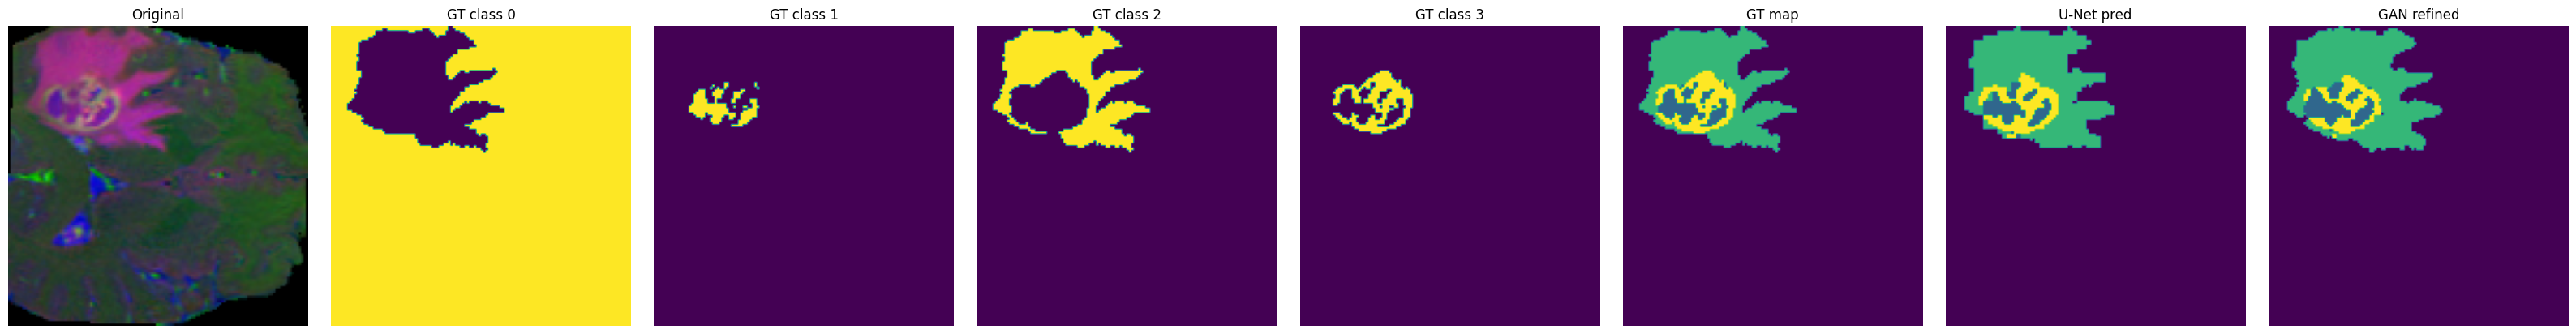

In [24]:
import torch.nn.functional as F

# --- Mid-training Sample Check with GAN Post-Processing (fixed) ---
sample_img = np.load(os.path.join(val_img_dir, "image_82", "slice_055.npy"))
sample_msk = np.load(os.path.join(val_msk_dir,   "image_82", "slice_055.npy"))

img_t = torch.from_numpy(sample_img).permute(2,0,1).unsqueeze(0).float().to(device)

hybrid.eval()
with torch.no_grad():
    raw_u = hybrid(img_t)   # 1×C×h×w  (likely 64×64)
    # --- Upsample to full size ---
    pred_u = F.interpolate(raw_u,
                           size=(IMG_SIZE, IMG_SIZE),
                           mode='bilinear',
                           align_corners=False)  # 1×C×128×128

G.eval()
with torch.no_grad():
    inp_g  = torch.cat([pred_u, img_t], dim=1)  # now both 128×128
    raw_g  = G(inp_g)                            
    # If G also downsamples internally, upsample its output too:
    pred_g = F.interpolate(raw_g,
                           size=(IMG_SIZE, IMG_SIZE),
                           mode='bilinear',
                           align_corners=False)  # 1×C×128×128

# Convert to numpy for plotting
pred_u_np  = pred_u .squeeze(0).cpu().numpy()  # C×128×128
pred_g_np  = pred_g .squeeze(0).cpu().numpy()  # C×128×128
gt_map     = np.argmax(sample_msk,  axis=-1)   # 128×128
pred_u_map = np.argmax(pred_u_np, axis=0)     # 128×128
pred_g_map = np.argmax(pred_g_np, axis=0)     # 128×128

# Plot (same as before)…
total_cols = NUM_CLASSES + 4
fig, axes = plt.subplots(1, total_cols, figsize=(4*total_cols, 4))

axes[0].imshow(sample_img); axes[0].set_title('Original'); axes[0].axis('off')
for c in range(NUM_CLASSES):
    axes[1+c].imshow(sample_msk[:,:,c])
    axes[1+c].set_title(f'GT class {c}'); axes[1+c].axis('off')
axes[1+NUM_CLASSES].imshow(gt_map)
axes[1+NUM_CLASSES].set_title('GT map'); axes[1+NUM_CLASSES].axis('off')
axes[2+NUM_CLASSES].imshow(pred_u_map )
axes[2+NUM_CLASSES].set_title('U-Net pred'); axes[2+NUM_CLASSES].axis('off')
axes[3+NUM_CLASSES].imshow(pred_g_map)
axes[3+NUM_CLASSES].set_title('GAN refined'); axes[3+NUM_CLASSES].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#final scores on test data

import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# --- Config & Paths ---
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE    = 128
NUM_CLASSES = 4
BATCH_SIZE  = 1

test_img_dir = os.path.join(data_root, "val/images_slicewise")
test_msk_dir = os.path.join(data_root, "val/masks_slicewise")

test_ds = BratsSlice(test_img_dir, test_msk_dir)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Load your best models ---
hybrid = Hybrid().to(device)
hybrid.load_state_dict(torch.load("hybridModel.pth", map_location=device))
hybrid.eval()

G = Pix2PixGenerator().to(device)
G.load_state_dict(torch.load("Generator.pth", map_location=device))
G.eval()

# --- Evaluation Loop ---
dice_hybrid = 0.0
dice_gan  = 0.0
n_slices  = len(test_ld)

with torch.no_grad():
    for img, gt in tqdm(test_ld, desc="Test Eval", unit="slice"):
        img = img.to(device)   # [1,3,128,128]
        gt  = gt.to(device)    # [1,4,128,128]

        # 1) U-Net raw
        pred_u = hybrid(img)
        # If hybrid is lower-res, upsample:
        if pred_u.shape[2:] != (IMG_SIZE, IMG_SIZE):
            pred_u = F.interpolate(pred_u, size=(IMG_SIZE,IMG_SIZE), mode='bilinear', align_corners=False)
        dice_hybrid += dice_coef(gt, pred_u).item()

        # 2) GAN post-processing
        inp_g  = torch.cat([pred_u, img], dim=1)   # [1,4+3,128,128]
        pred_g = G(inp_g)
        # If G is lower-res, upsample:
        if pred_g.shape[2:] != (IMG_SIZE, IMG_SIZE):
            pred_g = F.interpolate(pred_g, size=(IMG_SIZE,IMG_SIZE), mode='bilinear', align_corners=False)
        dice_gan  += dice_coef(gt, pred_g).item()

# --- Report ---
avg_hybrid = dice_hybrid / n_slices
avg_gan  = dice_gan  / n_slices

print(f"\nFinal average Dice score on TEST set:")
print(f"hybrid+eff+transformer only      : {avg_hybrid:.4f}")
print(f"U-Net+eff+transformer+Pix2Pix : {avg_gan:.4f}")


Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Test Eval: 100%|██████████| 11008/11008 [06:03<00:00, 30.31slice/s]


Final average Dice score on TEST set:
  • Hybrid only      : 0.9112
  • Hybrid + Pix2Pix : 0.9416


In [ ]:
hybrid = Hybrid().to(device)
hybrid.load_state_dict(torch.load("hybridModel.pth", map_location=device))
hybrid.eval()

G = Pix2PixGenerator().to(device)
G.load_state_dict(torch.load("Generator.pth", map_location=device))
G.eval()

In [ ]:
# --- Metric functions ---
def mean_iou(y_true, y_pred, eps=1e-6):
    """
    y_true: one-hot tensor (B, C, H, W)
    y_pred: raw logits (B, C, H, W)
    returns: mean IoU over classes and batch
    """
    # ensure same spatial dims
    if y_pred.shape[2:] != y_true.shape[2:]:
        y_pred = F.interpolate(y_pred, size=y_true.shape[2:], mode='bilinear', align_corners=False)
    # get predicted labels (B,H,W)
    pred_labels = y_pred.argmax(dim=1)
    true_labels = y_true.argmax(dim=1)
    
    iou_per_class = []
    for c in range(y_true.size(1)):
        # build binary masks
        pred_mask = (pred_labels == c).cpu().numpy().astype(np.uint8)
        true_mask = (true_labels == c).cpu().numpy().astype(np.uint8)
        # intersection & union per slice in batch
        intersect = (pred_mask & true_mask).sum(axis=(1,2))
        union     = (pred_mask | true_mask).sum(axis=(1,2)) + eps
        iou_per_class.append((intersect / union).mean())
    return float(np.mean(iou_per_class))


In [ ]:
# --- Evaluation Loop ---
iou_hybrid, iou_gan = 0.0, 0.0
n_slices          = len(test_ld)

with torch.no_grad():
    for img, gt in tqdm(test_ld, desc="Test Eval"):
        img = img.to(device)   # [1,3,H,W]
        gt  = gt.to(device)    # [1,4,H,W] (one-hot)
        
        # 1) Hybrid raw
        pred_u = hybrid(img)
        pred_u = F.interpolate(pred_u, size=gt.shape[2:], mode='bilinear', align_corners=False)
        
        # compute IoU
        iou_hybrid += mean_iou(gt, pred_u)
                
        # 2) GAN post-processing
        inp_g  = torch.cat([pred_u, img], dim=1)
        pred_g = G(inp_g)
        pred_g = F.interpolate(pred_g, size=gt.shape[2:], mode='bilinear', align_corners=False)
        
        iou_gan += mean_iou(gt, pred_g)
        

# --- Report ---
avg_iou_hybrid = iou_hybrid / n_slices
avg_iou_gan  = iou_gan  / n_slices

print("\nFinal average scores on TEST set:")
print(f"Hybrid model only: ")
print(f"Mean IoU: {avg_iou_hybrid:.4f}")
print(f"Hybrid+Pix2Pix GAN")
print(f"Mean IoU: {avg_iou_gan:.4f}")


Test Eval: 100%|██████████| 11008/11008 [09:26:24<00:00,  3.09s/it]



Final average scores on TEST set:
Hybrid model only: 
Mean IoU: 0.8474
Hybrid+Pix2Pix GAN
Mean IoU: 0.8757
